### Analysis of Chip Product Customer Segments in Retail Companies

#### Background

At a retail company, the Chips Category Manager wants to better understand the types of customers who buy chips and their purchasing behavior. As part of the data analysis team, I was instructed by my manager to make a customer analysis for the chips category. This analysis will be included in the strategic plan for the next half year.

#### Data Understanding

There is 2 dataset, transaction data and purchase behavior. The transaction data consists of 264836 rows and 8 columns. The following is an explanation of each column;

- DATE: the date when the transactions occurred. 
- STORE_NBR: the store number or identifier where the transaction took place. Each store  have a unique number.
- LYLTY_CARD_NBR:  a loyalty card number associated with the customer making the transaction. Each customer  have a unique number.
- TXN_ID:  transaction identifier or unique transaction number for each purchase. 
- PROD_NBR: product number. Each product have a unique number.
- PROD_NAME: description of the product. It is also contain information of size pack and brand name of product.
- PROD_QTY: the quantity of chips products purchased in each transaction. 
- TOT_SALES: the total sales amount for each transaction. 

The purchase data consist of 72637 rows and 3 columns, The following is an explanation of each column;
- LYLTY_CARD_NBR:  a loyalty card number associated with the customer making the transaction. Each customer  have a unique number.
- LIFESTAGE: customer attribute that identifies whether a customer has a family or not and what point in life they are at e.g. are their children in pre-school/primary/secondary school.
- PREMIUM_CUSTOMER: customer segmentation used to differentiate shoppers by the price point of products they buy and the types of products they buy. It is used to identify whether customers may spend more for quality or brand or whether they will purchase the cheapest options.

#### Define Problem Statement or Metric

- Who spends the most on chips (total sales) by lifestage and how premium their in purchasing behaviour
- How many customers are in each segment 
- How many chips are bought per customer by segment
- What’s the average chip price by customer segment
- Who is the best customer segment being targeted
- What purchasing behavior by customer segment targeted

#### Data Cleaning

In [1]:
# Import Lybrary
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

# lybrary for statistic
from scipy import stats

In [2]:
# Load the dataset
transaction_data = pd.read_excel('QVI_transaction_data.xlsx')
purchase_data = pd.read_csv("QVI_purchase_behaviour.csv")

##### 1. Examine Transaction Data

In [3]:
# Display transaction data
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [4]:
# Print column info
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


Column of DATE is an Integer format. It's need to convert to datetype format

In [5]:
# Convert DATE column to a date format
# A quick Google search tells that Excel integer dates begin on 30 Dec 1899
excel_reference_date = pd.Timestamp('1899-12-30')
transaction_data['DATE'] = excel_reference_date + pd.to_timedelta(transaction_data['DATE'], unit='D')

In [6]:
# Cheking Date format after convert
transaction_data['DATE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 264836 entries, 0 to 264835
Series name: DATE
Non-Null Count   Dtype         
--------------   -----         
264836 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.0 MB


Converting date format is Succeed.

Next, cheking DATE column

In [7]:
transaction_by_date = transaction_data.groupby(['DATE']).size().reset_index().rename(columns={0: 'COUNT'})
transaction_by_date

,DATE,COUNT
0,2018-07-01,724
1,2018-07-02,711
2,2018-07-03,722
3,2018-07-04,714
4,2018-07-05,712
...,...,...
359,2019-06-26,723
360,2019-06-27,709
361,2019-06-28,730
362,2019-06-29,745


Transaction Date range from 01-07-2018 until 30-06-2019. Totals days should be 365 days, but it's 364 days. it's look like there is missing day. let's find it

In [8]:
# Create sequence of dates
all_date = pd.date_range(start='2018-07-01', end='2019-06-30', freq='D')
all_date = pd.DataFrame({'DATE': all_date})
all_date

,DATE
0,2018-07-01
1,2018-07-02
2,2018-07-03
3,2018-07-04
4,2018-07-05
...,...
360,2019-06-26
361,2019-06-27
362,2019-06-28
363,2019-06-29


In [9]:
# Merge all_date with transaction_by_date
transaction_all_date = all_date.merge(transaction_by_date, on='DATE', how='left')

# find missing date
transaction_all_date[transaction_all_date['COUNT'].isnull()]

,DATE,COUNT
177,2018-12-25,NaN


That's great we successfuly found that on 25 December 2018 there is no transaction. it's make sense, because shops being closed on Christmas day.

Next!, Exploring PROD_NAME column. There is information about pack size and brand name of product

In [10]:
transaction_data.groupby(['PROD_NAME']).size()

PROD_NAME
Burger Rings 220g                         1564
CCs Nacho Cheese    175g                  1498
CCs Original 175g                         1514
CCs Tasty Cheese    175g                  1539
Cheetos Chs & Bacon Balls 190g            1479
                                          ... 
WW Sour Cream &OnionStacked Chips 160g    1483
WW Supreme Cheese   Corn Chips 200g       1509
Woolworths Cheese   Rings 190g            1516
Woolworths Medium   Salsa 300g            1430
Woolworths Mild     Salsa 300g            1491
Length: 114, dtype: int64

It seems that not all products are chips. identified there is a salsa product. so it's need to removed

In [11]:
# Identify data that contains Salsa Product
transaction_data['SALSA'] = transaction_data['PROD_NAME'].str.lower().str.contains('salsa')

# Remove salsa product
transaction_data= transaction_data[transaction_data['SALSA']== False].drop(columns=['SALSA'])

In [12]:
transaction_data.groupby(['PROD_NAME']).size()

PROD_NAME
Burger Rings 220g                         1564
CCs Nacho Cheese    175g                  1498
CCs Original 175g                         1514
CCs Tasty Cheese    175g                  1539
Cheetos Chs & Bacon Balls 190g            1479
                                          ... 
WW Original Corn    Chips 200g            1495
WW Original Stacked Chips 160g            1487
WW Sour Cream &OnionStacked Chips 160g    1483
WW Supreme Cheese   Corn Chips 200g       1509
Woolworths Cheese   Rings 190g            1516
Length: 105, dtype: int64

Extract pack size and brand name of product from PROD_NAME column

In [13]:
# Extract pack size
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract('(\d+)'). astype(int)

# Extract brand name 
transaction_data['BRAND'] = transaction_data['PROD_NAME'].str.split(' ').str[0].str.upper()

In [14]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCS
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,SMITHS
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,SMITHS
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,KETTLE


In [15]:
# Cheking PACK_SIZE column
transaction_data.groupby(['PACK_SIZE']).size().reset_index().rename(columns={0: 'COUNT'})

,PACK_SIZE,COUNT
0,70,1507
1,90,3008
2,110,22387
3,125,1454
4,134,25102
5,135,3257
6,150,40203
7,160,2970
8,165,15297
9,170,19983


It's look like make sense, the smallest size is 70 gram and the largest 380 gram.

In [16]:
# Cheking for BRAND column
transaction_data.groupby(['BRAND']).size().reset_index().rename(columns= {0: 'COUNT'})

,BRAND,COUNT
0,BURGER,1564
1,CCS,4551
2,CHEETOS,2927
3,CHEEZELS,4603
4,COBS,9693
5,DORITO,3185
6,DORITOS,22041
7,FRENCH,1418
8,GRAIN,6272
9,GRNWVES,1468


Identified an inconsistence brand name. Some of the brand names look like they are same brands - such as RED and RRD, which are both Red Rock Deli chips. Let’s combine these together.

In [17]:
# Collecting inconsistence brand name
inconsistence_brand_name = {
    "RED" : "RRD",
    "SNBTS" : "SUNBITES",
    "INFZNS" : "INFUZIONS",
    "WW" : "WOOLWORTHS",
    "SMITH" : "SMITHS",
    "NCC" : "NATURAL",
    "DORITO" : "DORITOS",
    "GRAIN" : "GRNWVES"
}

# Replace inconsistence brand name
transaction_data['BRAND'] = transaction_data['BRAND'].replace(inconsistence_brand_name)

In [18]:
# Cheking after cleaned inconsistence brand name
transaction_data.groupby(['BRAND']).size().reset_index().rename(columns={0: "COUNT"})

,BRAND,COUNT
0,BURGER,1564
1,CCS,4551
2,CHEETOS,2927
3,CHEEZELS,4603
4,COBS,9693
5,DORITOS,25226
6,FRENCH,1418
7,GRNWVES,7740
8,INFUZIONS,14201
9,KETTLE,41288


Next!, we need to check summary statistic for columns that contain number. 

In [19]:
# Print Summary statistic
transaction_data.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PACK_SIZE
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000,246742.000000
mean,2018-12-30 01:19:01.211467520,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322,175.585178
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000,70.000000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000,150.000000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000,170.000000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000,175.000000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000,380.000000
std,NaN,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828,59.434727


Product quantity appears to have an outlier which we should investigate further. Let’s investigate further the case where 200 packets of chips are bought in one transaction.

In [20]:
# filter dataset to find the outliers
transaction_data[transaction_data['PROD_QTY']== 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,380,DORITOS
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,380,DORITOS


There are two transactions where 200 packets of chips are bought in one transaction and both of these transactions where by the same customer. Lets check if customer have other transaction.

In [21]:
transaction_data[transaction_data['LYLTY_CARD_NBR']== 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,380,DORITOS
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,380,DORITOS


It looks like this customer has only had the two transactions over the year and is not an ordinary retail customer. The customer might be buying chips for commercial purposes instead. We’ll remove this loyalty card number from further analysis.

In [22]:
# Filter out the customer based on the loyalty card number
transaction_data = transaction_data[transaction_data['LYLTY_CARD_NBR'] != 226000]

In [23]:
# Print Summary statistic
transaction_data.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PACK_SIZE
count,246740,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000,246740.000000
mean,2018-12-30 01:18:58.448569344,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113,175.583521
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000,70.000000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000,150.000000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000,170.000000
75%,2019-03-31 00:00:00,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000,175.000000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000,380.000000
std,NaN,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897,59.432118


That’s better now. Product quantity with;
min = 1
max = 5
average= 1.9
median = 2. 
Total sales with;
min = 1
max = 29.5
average = 7,3
median = 7.4

Next!, Cheking for missing values and duplicate

In [24]:
# Cheking missing values
transaction_data.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
PACK_SIZE         0
BRAND             0
dtype: int64

There is no missing values

In [25]:
# Cheking Duplicated data
transaction_data.duplicated().sum()

1

In [26]:
# Delete duplicate data
transaction_data.drop_duplicates(inplace=True)

In [27]:
# Cheking for duplicated after remove
transaction_data.duplicated().sum()

0

In [28]:
# Display Data transaction
transaction_data

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCS
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,SMITHS
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,SMITHS
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,KETTLE
...,...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175,KETTLE
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175,TOSTITOS
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170,DORITOS
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150,DORITOS


##### 2. Examining Purchase Data

In [29]:
# Display the data
purchase_data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [30]:
# Print data info
purchase_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


Lets check for LIFESTAGE and PREMIUM_CUSTOMER columns

In [31]:
# Check LIFESTAGE Column
purchase_data.groupby(['LIFESTAGE']).size().reset_index().rename(columns = {0: "COUNT"})

,LIFESTAGE,COUNT
0,MIDAGE SINGLES/COUPLES,7275
1,NEW FAMILIES,2549
2,OLDER FAMILIES,9780
3,OLDER SINGLES/COUPLES,14609
4,RETIREES,14805
5,YOUNG FAMILIES,9178
6,YOUNG SINGLES/COUPLES,14441


In [32]:
# Check PREMIUM_CUSTOMER Column
purchase_data.groupby(['PREMIUM_CUSTOMER']).size().reset_index().rename(columns={0:"COUNT"})

,PREMIUM_CUSTOMER,COUNT
0,Budget,24470
1,Mainstream,29245
2,Premium,18922


It's look good. 
next, Check missing valus and duplicated data

In [33]:
# Checking for missing value
purchase_data.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

There is no missing values

In [34]:
# Cheking for duplicated
purchase_data.duplicated().sum()

0

As there do not seem to be any issues with the purchase data, we can now go ahead and join the transaction and customer data sets together

##### 3. Join The Dataset

In [35]:
# Merge the dataset using left outer join
data = pd.merge(transaction_data, purchase_data, on='LYLTY_CARD_NBR', how='left')

In [36]:
# display the data
data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCS,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,SMITHS,MIDAGE SINGLES/COUPLES,Budget
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,SMITHS,MIDAGE SINGLES/COUPLES,Budget
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,KETTLE,MIDAGE SINGLES/COUPLES,Budget


In [37]:
# Cheking for dimension of Data
print("Dimension of Data transaction :",transaction_data.shape)
print("Dimension of Data Purchase :",purchase_data.shape)
print("Dimension of Data after join :",data.shape)

Dimension of Data transaction : (246739, 10)
Dimension of Data Purchase : (72637, 3)
Dimension of Data after join : (246739, 12)


The dataset was successfuly cleaned, we can save to csv.

In [38]:
# Save the data to csv file
data.to_csv('transaction_and_ purchase_data.csv')

#### Exploratory Data Analysis

##### 1. Who Spend The Most on Chips/ Total Sales in Each Customer Segement

<Figure size 800x400 with 0 Axes>

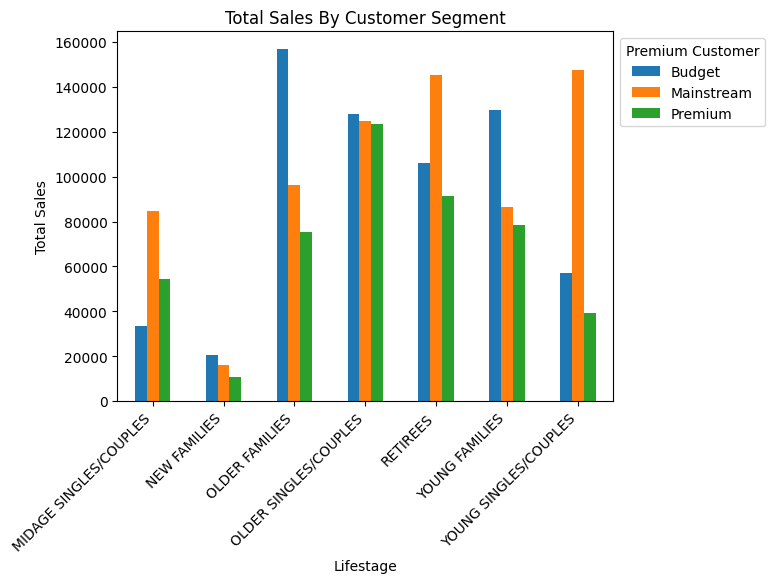

In [39]:
# Total sales by 'LIFESTAGE' and 'PREMIUM_CUSTOMER'
sales = data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER'])['TOT_SALES'].sum().unstack()

# Create plot for Total Sales by customer segment
plt.figure(figsize=(8,4))
sales.plot(kind='bar')

plt.title("Total Sales By Customer Segment")
plt.xlabel("Lifestage")
plt.ylabel("Total Sales")
plt.xticks(rotation = 45, fontsize=10, ha='right')

# Adjust the legend position 
plt.legend(title="Premium Customer",fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

Sales are coming mainly from 
- Budget - older families
- Mainstream - young singles/couples, 
- and Mainstream - retirees

##### 2. Total Customers in Each Segment

<Figure size 800x400 with 0 Axes>

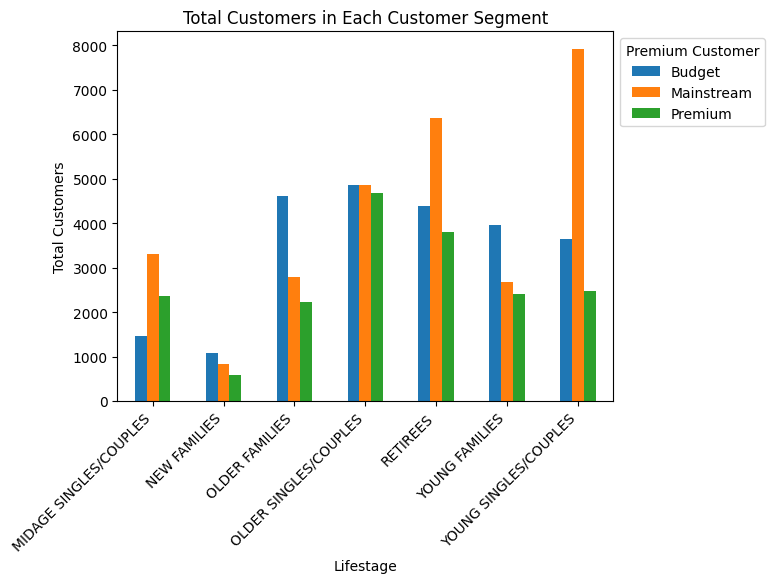

In [40]:
# Calculate total customers in each segment
customers = data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().unstack()

# Create plot for Total Customer by customer segment
plt.figure(figsize=(8,4))
customers.plot(kind='bar')

plt.title("Total Customers in Each Customer Segment")
plt.xlabel("Lifestage")
plt.ylabel("Total Customers")
plt.xticks(rotation = 45, fontsize=10, ha='right')

# Adjust the legend position 
plt.legend(title="Premium Customer",fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

Total Customers are mostly from:
- Mainstream - young singles/couples 
- Mainstream - retirees who buy chips. 
- All segment older singles/couples

##### 3. Total Chips are Bought in each Customer Segment

<Figure size 800x400 with 0 Axes>

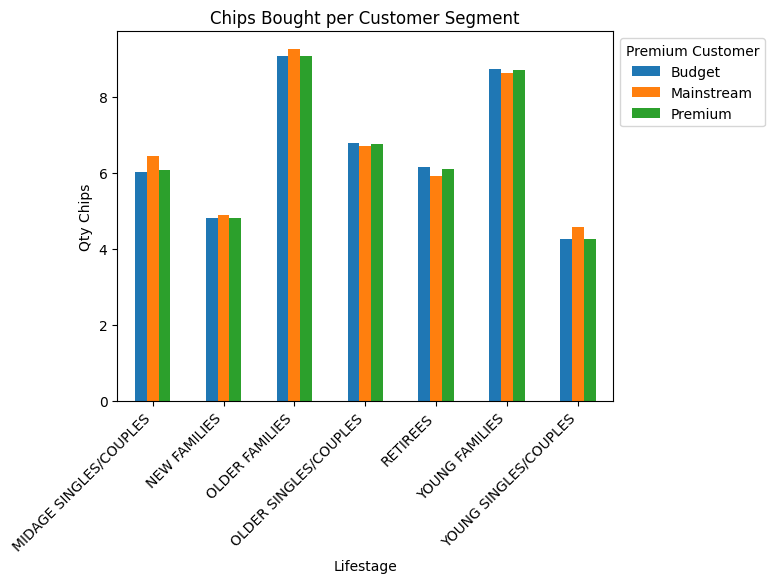

In [41]:
# Calculate chips bought per customer Segment
chips_per_customers = data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER'])['PROD_QTY'].sum().unstack()/customers

# Create plot for chips per customers by customer segment
plt.figure(figsize=(8,4))
chips_per_customers.plot(kind='bar')

plt.title("Chips Bought per Customer Segment")
plt.xlabel("Lifestage")
plt.ylabel("Qty Chips")
plt.xticks(rotation = 45, fontsize=10, ha='right')

# Adjust the legend position 
plt.legend(title="Premium Customer",fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

Older families and young families in general buy more chips per customer

##### 4. Average Chip Price Per Unit by Customer Segment

<Figure size 800x400 with 0 Axes>

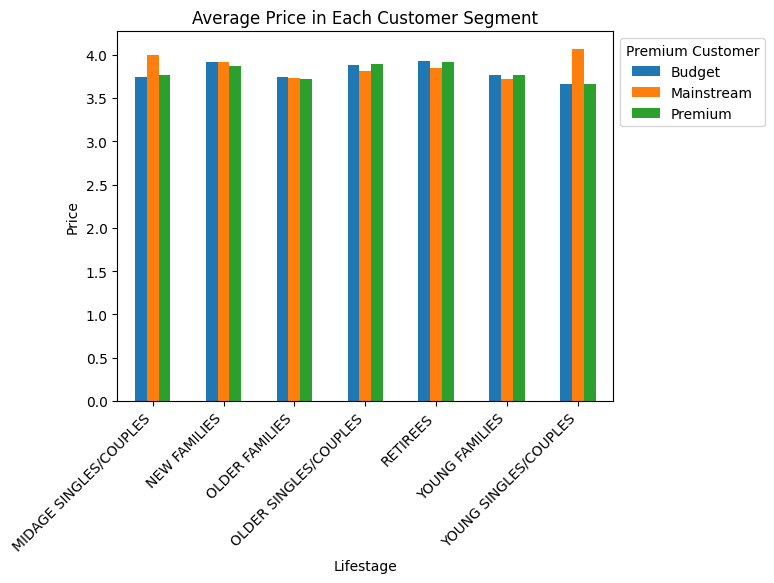

In [42]:
# Calculate average price per unit by customer segment
data['PRICE'] = data['TOT_SALES']/data['PROD_QTY']
avg_chips_price_by_segment = data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER'])['PRICE'].mean().unstack()

# Create plot for average chips price per unit
plt.figure(figsize=(8,4))
avg_chips_price_by_segment.plot(kind='bar')

plt.title("Average Price in Each Customer Segment")
plt.xlabel("Lifestage")
plt.ylabel("Price")
plt.xticks(rotation = 45, fontsize=10, ha='right')

# Adjust the legend position 
plt.legend(title="Premium Customer",fontsize=10, bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

Mainstream midage and young singles and couples are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to
buy healthy snacks and when they buy chips, this is mainly for entertainment purposes rather than their own
consumption. This is also supported by there being fewer premium midage and young singles and couples
buying chips compared to their mainstream counterparts.

As the difference in average price per unit isn’t large, we can check if this difference is statistically different

In [43]:
# Perform an independent t‐test between mainstream vs premium and budget midage and young singles and couples
# Define the lifestages and customer groups
lifestages = ["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"]
mainstream_group = data[(data['LIFESTAGE'].isin(lifestages)) & (data['PREMIUM_CUSTOMER'] == "Mainstream")]
non_mainstream_group = data[(data['LIFESTAGE'].isin(lifestages)) & (data['PREMIUM_CUSTOMER'] != "Mainstream")]

# Perform an independent t-test
t_statistic, p_value = stats.ttest_ind(mainstream_group['PRICE'], non_mainstream_group['PRICE'], alternative='greater')

# Print the t-statistic and p-value
print("Independent t-test results:")
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

# Check if the difference is statistically significant (using a significance level of 0.05)
if p_value < 0.05:
    print("The difference in average price per unit is statistically significant.")
else:
    print("The difference in average price per unit is not statistically significant.")


Independent t-test results:
t-statistic: 37.83196107667815
p-value: 1.11782280577468e-309
The difference in average price per unit is statistically significant.


The t-test results in a p-value 1.11782280577468e-309, i.e. the unit price for mainstream, young and midage singles and couples are significantly higher than that of budget or premium, young and midage singles and couples.

##### 5. Choosing Customer Target

As analysis have been conducted, we could suggest that mainstream - young singles/couples being customers segment targeted. Here are some considerations:
- One of the most Sales come from mainstream - young singles/couples
- Total customers segment mostly from mainstream - young singles/couples
- Mainstream young singles/couples are more willing to pay more per packet of chips compared to other
- Chips Bought per Customer on mainstream - young singles/couples are lower than other. This could be an opportunity to improvement.

##### 6. Find Purchasing Behavior by Customer  Segment Targeted

Let’s find out if Customer Segment Targeted (mainstream - young singles/couples) tend to buy a particular brand of chips. We could analysis their affinity to buy particular brand by calculating proportion quantity each brand on customer targeted compare to others.

In [45]:
# Filter data for "Mainstream, young singles/couples" and other segments
segment1 = data[(data['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") & (data['PREMIUM_CUSTOMER'] == "Mainstream")]
other = data[~((data['LIFESTAGE'] == "YOUNG SINGLES/COUPLES") & (data['PREMIUM_CUSTOMER'] == "Mainstream"))]

# Calculate Proportion Quantity Segment1 and Other by Brand 
quantity_segment1_by_brand = (segment1.groupby('BRAND')['PROD_QTY'].sum()/segment1['PROD_QTY'].sum()).reset_index().rename(columns={'PROD_QTY': 'PROPORTION _QTY_TARGET_SEGMENT'})
quantity_other_by_brand = (other.groupby('BRAND')['PROD_QTY'].sum()/other['PROD_QTY'].sum()).reset_index().rename(columns={'PROD_QTY': 'PROPORTION_QTY_OTHER'})

# Merge brand proportions for segment1 and other segments
brand_proportions = pd.merge(quantity_segment1_by_brand, quantity_other_by_brand, on='BRAND', how='inner')

# Calculate affinity to brand
brand_proportions['AFFINITY_TO_BRAND'] = brand_proportions['PROPORTION _QTY_TARGET_SEGMENT'] / brand_proportions['PROPORTION_QTY_OTHER']

brand_proportions.sort_values('AFFINITY_TO_BRAND', ascending=False)

,BRAND,PROPORTION _QTY_TARGET_SEGMENT,PROPORTION_QTY_OTHER,AFFINITY_TO_BRAND
18,TYRRELLS,0.031553,0.025693,1.228090
17,TWISTIES,0.046184,0.037877,1.219314
5,DORITOS,0.122761,0.101075,1.214547
9,KETTLE,0.197985,0.165554,1.195891
16,TOSTITOS,0.045411,0.037978,1.195708
11,PRINGLES,0.119420,0.100635,1.186665
4,COBS,0.044638,0.039049,1.143119
8,INFUZIONS,0.064679,0.057065,1.133430
15,THINS,0.060373,0.056987,1.059418
7,GRNWVES,0.032712,0.031188,1.048868


We can see that :
- Mainstream young singles/couples are 22% more likely to purchase Tyrrells chips compared to the rest of the population
- Mainstream young singles/couples are 56% less likely to purchase Burger Rings compared to the rest of the population


let's do the same analysis to pack size to find costumer targeted affinity to buy particular pack size.

In [46]:
# Calculate Proportion Quantity Segment1 and Other by Pack Size
quantity_segment1_by_pack = (segment1.groupby('PACK_SIZE')['PROD_QTY'].sum()/segment1['PROD_QTY'].sum()).reset_index().rename(columns={'PROD_QTY': 'PROPORTION _QTY_TARGET_SEGMENT'})
quantity_other_by_pack = (other.groupby('PACK_SIZE')['PROD_QTY'].sum()/other['PROD_QTY'].sum()).reset_index().rename(columns={'PROD_QTY': 'PROPORTION_QTY_OTHER'})

# Merge pack size proportions for segment1 and other segments
pack_proportions = pd.merge(quantity_segment1_by_pack, quantity_other_by_pack, on='PACK_SIZE', how='inner')

# Calculate affinity to brand
pack_proportions['AFFINITY_TO_PACK_SIZE'] = pack_proportions['PROPORTION _QTY_TARGET_SEGMENT'] / pack_proportions['PROPORTION_QTY_OTHER']

pack_proportions.sort_values('AFFINITY_TO_PACK_SIZE', ascending=False)

,PACK_SIZE,PROPORTION _QTY_TARGET_SEGMENT,PROPORTION_QTY_OTHER,AFFINITY_TO_PACK_SIZE
17,270,0.031829,0.025096,1.268281
19,380,0.032160,0.025584,1.257024
18,330,0.061284,0.050162,1.221711
4,134,0.119420,0.100635,1.186665
2,110,0.106280,0.089792,1.183632
14,210,0.029124,0.025121,1.159313
5,135,0.014769,0.013075,1.129505
16,250,0.014355,0.012781,1.123161
9,170,0.080773,0.080986,0.997365
6,150,0.157598,0.163421,0.964368


It looks like Mainstream young singles/couples are 26% more likely to purchase a 270 gram pack of chips compared to the rest of the population. But let’s dive into what brands sell this pack size.

In [47]:
pack_size270 = data[data['PACK_SIZE'] == 270]
pack_size270['PROD_NAME'].unique()

array(['Twisties Cheese     270g', 'Twisties Chicken270g'], dtype=object)

Twisties are the only brand offering 270g packs and so this may instead be reflecting a higher likelihood of
purchasing Twisties.

#### Conclusion

- Mostly sales come from Budget - older families, Mainstream - young singles/couples, and Mainstream - retirees shoppers. We found that the high spend in chips for mainstream young singles/couples and retirees is due to there being more of them than other buyers.
- Mainstream, midage and young singles and couples are also more likely to pay more per packet of chips. This is indicative of impulse buying behaviour.
- Based on our analysis, we could consider that mainstream - young singles/couples who are the customers segment targeted.
- Mainstream young singles and couples are 22% more likely to purchase Tyrrells chips compared to the rest of the population. 
- Mainstream young singles/couples are 26% more likely to purchase a 270 gram pack of chips compared to the rest of the population